# Installs

In [1]:
!pip install inflection
!pip install boruta
!pip install xgboost

# Imports

## Libraries

In [1]:
import pandas as pd
import inflection
import math
import locale
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import timedelta
%matplotlib inline
import numpy as np
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn import metrics as mt
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
import random
import pickle

## Data

In [222]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('datasets/store.csv', low_memory=False)

In [3]:
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
885263,739,1,2013-04-29,11336,855,1,1,0,0,d,c,2770.0,6.0,2008.0,1,22.0,2011.0,"Jan,Apr,Jul,Oct"


# Funcions

In [4]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

In [5]:

def ml_error(model_name, y, y_hat):
    mae = mt.mean_absolute_error(y, y_hat)
    #mape = mt.mean_absolute_percentage_error(y, y_hat) # its being different. I didnt understand why yet
    mape = np.mean(np.abs( (y - y_hat) / y ))
    rmse = np.sqrt(mt.mean_squared_error(y, y_hat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

In [6]:
def cross_validation(model, x_training, k_fold, verbose=False):
    df_metrics = pd.DataFrame()
    for k in reversed(range(1, k_fold + 1)):
        if verbose:
            print('KFold nr: {}'.format(k))
        vld_start_date = x_training['date'].max() - timedelta(weeks=k * 6)
        vld_end_date = x_training['date'].max() - timedelta(weeks=k * 0)

        training = x_training[x_training['date'] < vld_start_date]
        validation = x_training[(x_training['date'] >= vld_start_date) & (x_training['date'] <= vld_end_date)]

        xtraining = training.drop(columns=['date', 'sales'])
        ytraining = training['sales']

        xvalidation = validation.drop(columns=['date', 'sales'])
        yvalidation = validation['sales']

        #lr = LinearRegression()
        model.fit(xtraining, ytraining)
        yhatvalidation = model.predict(xvalidation)

        m_result = ml_error(model.__class__.__name__, np.expm1(yvalidation), np.expm1(yhatvalidation))
        m_result.insert(0, 'k', k)
        df_metrics = pd.concat([df_metrics,m_result])
        df_summary = pd.DataFrame({
            'method': ['MAE', 'MAPE', 'RMSE'],
            'mean': [df_metrics['MAE'].mean(), df_metrics['MAPE'].mean(), df_metrics['RMSE'].mean()],
            'std': [df_metrics['MAE'].std(), df_metrics['MAPE'].std(), df_metrics['RMSE'].std()],
        }) 
    return df_metrics, df_summary

In [156]:
def mean_percented_error(y, y_hat):
    return np.mean((y - y_hat) / y)

In [157]:
def mean_absolute_percentage_error(y, y_hat):
    return np.mean(np.abs( (y - y_hat) / y ))

# Data Description

## Rename Columns

In [7]:
df1 = df_raw.copy()
old_cols = df1.columns
new_cols = list(map(inflection.underscore, old_cols))
df1.columns = new_cols
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimensions

In [8]:
df1.shape

(1017209, 18)

## Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'], )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NAs

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NAs

In [11]:
# competition_distance               2642
max_value = 10 * df1['competition_distance'].max()
df1.loc[df1['competition_distance'].isna(), 'competition_distance'] = max_value

# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply(lambda row: row['date'].month if math.isnan(row['competition_open_since_month']) else row['competition_open_since_month'], axis=1)

# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply(lambda row: row['date'].year if math.isnan(row['competition_open_since_year']) else row['competition_open_since_year'], axis=1)

# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply(lambda row: row['date'].week if math.isnan(row['promo2_since_week']) else row['promo2_since_week'], axis=1)

# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda row: row['date'].year if math.isnan(row['promo2_since_year']) else row['promo2_since_year'], axis=1)

# promo_interval                  508031
df1.loc[df1['promo_interval'].isna(), 'promo_interval'] = ''

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## Check Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object


## Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [17]:
num_metrics = num_attributes.describe().T
num_metrics = num_metrics.rename(columns={'25%': 'q1', '50%': 'median', '75%': 'q3'})
num_metrics['amplitude'] = num_metrics['max'] - num_metrics['min']
num_metrics['ifq'] = num_metrics['q3'] - num_metrics['q1']
num_metrics['skew'] = num_attributes.apply(lambda x: x.skew())
num_metrics['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())
num_metrics = num_metrics[['mean', 'median', 'min', 'q1', 'q3', 'max', 'std', 'ifq', 'amplitude', 'skew', 'kurtosis']]
num_metrics

,mean,median,min,q1,q3,max,std,ifq,amplitude,skew,kurtosis
store,558.429727,558.0,1.0,280.0,838.0,1115.0,321.908651,558.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.0,2.0,6.0,7.0,1.997391,4.0,6.0,0.001593,-1.246873
sales,5773.818972,5744.0,0.0,3727.0,7856.0,41551.0,3849.926175,4129.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,0.0,405.0,837.0,7388.0,464.411734,432.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.0,1.0,1.0,1.0,0.375539,0.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.0,0.0,1.0,1.0,0.485759,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.0,0.0,0.0,1.0,0.383056,0.0,1.0,1.677842,0.815154
competition_distance,7386.296140,2330.0,20.0,710.0,6910.0,758600.0,39101.217148,6200.0,758580.0,18.434533,350.869718
competition_open_since_month,6.786849,7.0,1.0,4.0,10.0,12.0,3.311087,6.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,1900.0,2008.0,2014.0,2015.0,5.515593,6.0,115.0,-7.235657,124.071304


/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customers', ylabel='Density'>

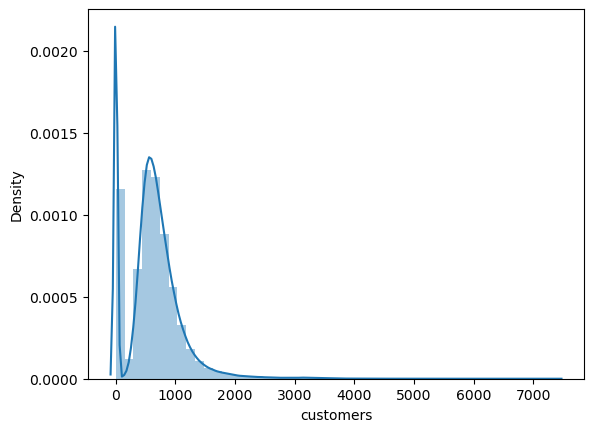

In [18]:
sns.distplot(df1['customers'])

### Categorical Attributes


In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

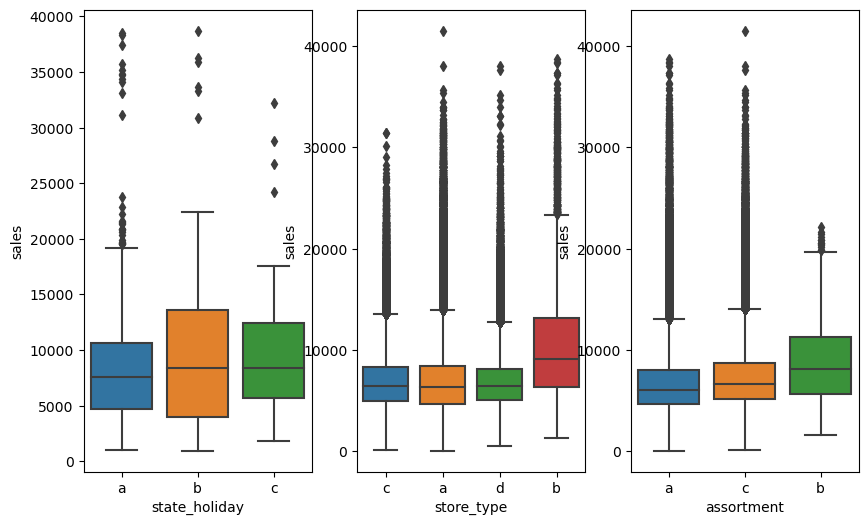

In [20]:
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.subplot(1,3,2)
aux1 = df1[(df1['sales'] > 0)]
sns.boxplot(x='store_type', y='sales', data=aux1)
plt.subplot(1,3,3)
aux1 = df1[(df1['sales'] > 0)]
sns.boxplot(x='assortment', y='sales', data=aux1)
plt.show()
plt.close()


# Hipotesis

## Mindmap

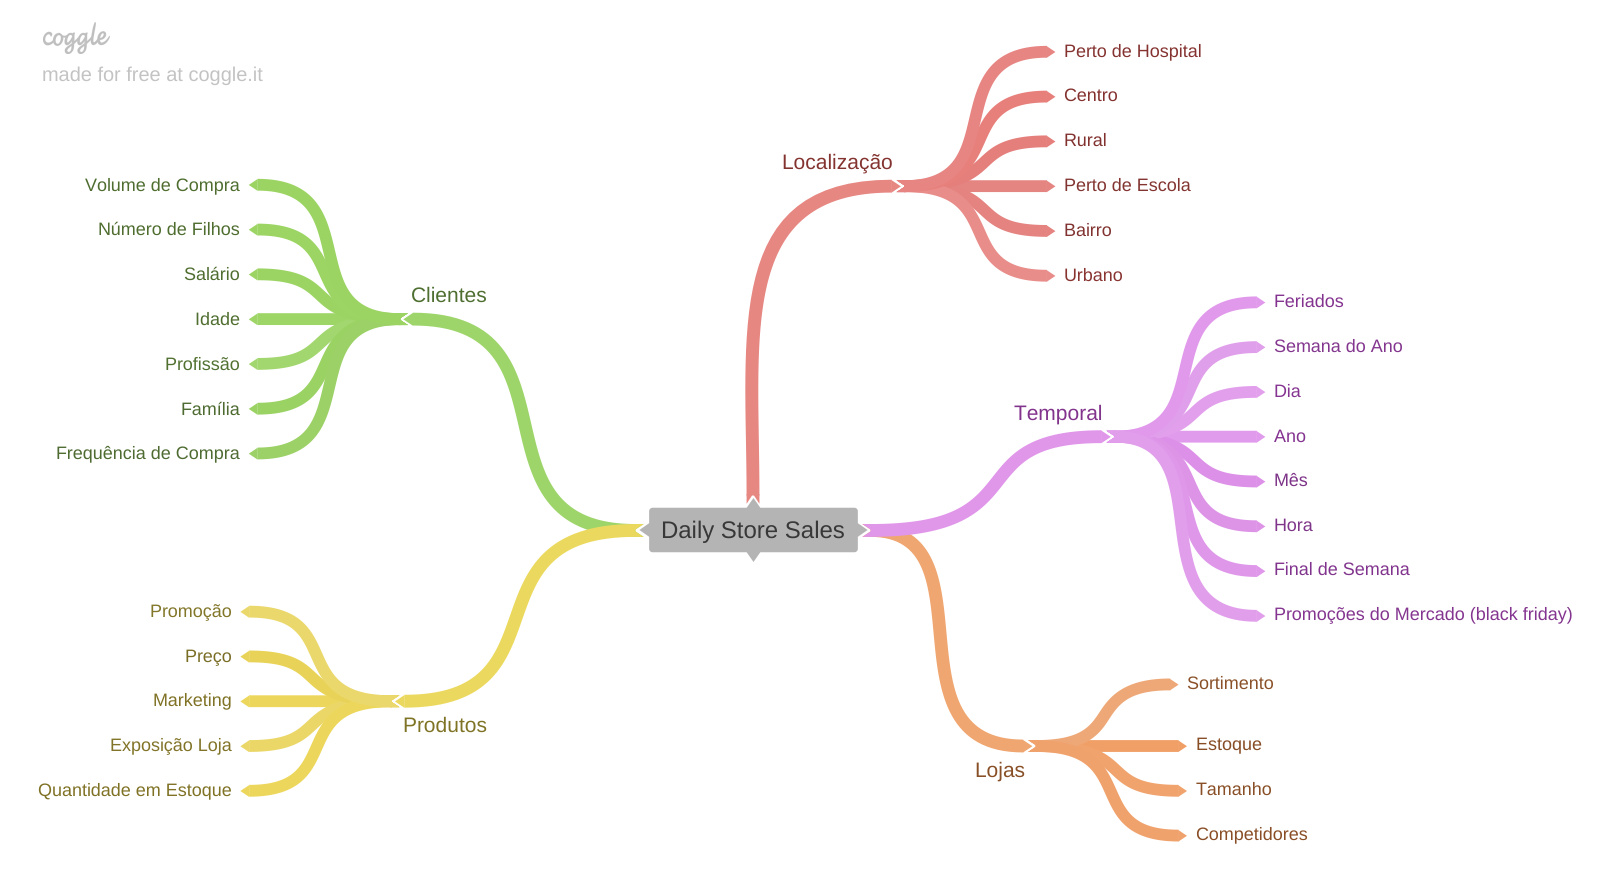

In [22]:
Image.open('./images/mind_map_hipotesis.png')

## Creating Hipotesis

### Store Hipotesis

- Lojas com maior quadro de funcionarios deveriam vender mais  
- Lojas com maior estoque deveriam vender mais  
- Lojas com maior porte deveriam vender mais  
- Lojas com menor porte deveriam vender menos  
- Lojas com maior sortimento deveriam vender mais  

### Product Hipotesis

- Lojas que investem mais em marketing deveriam vender mais  
- Lojas que expoem mais os produtos nas vitrines deveriam vender mais  
- Lojas com menores preços deveriam vender mais  
- Lojas que tem menores preços por mais tempo deveriam vender mais  
- Lojas com maior quantidade de produtos em estoque deveriam vender mais  
- Lojas com campanhas de promoção deveriam vender mais  

### Time Hipotesis

- Lojas que tem mais feriados deveriam vender menos  
- Lojas que abrem nos primeiros seis meses deveriam vender mais  
- Lojas que abrem nos finais de semana deveriam vender mais  

## Selecting Hipotesis

1 - Lojas com sortimentos deveriam vender mais  
2 - Lojas com competidores mais próximos deveriam vender menos  
3 - Lojas com competidores a mais tempo deveriam vender mais  
4 - Lojas com promoções ativas por mais tempo deveriam vender mais  
5 - Lojas com mais dias de promoção deveriam vender mais  
6 - Lojas com mais promoções consecutivas deveriam vender mais  
7 - Lojas abertas durante o feriado de natal deveriam vender mais  
8 - Lojas deveriam vender mais ao longo dos anos  
9 - Lojas deveriam vender mais no segundo semestre do ano  
10 - Lojas deveriam vender mais depois do dia 10 de cada mês  
11 - Lojas deveriam vender menos aos finais de semana  
12 - Lojas deveriam vender menos durante os feriados escolares  

# Feature Engineering

In [21]:
# definir se a loja estava em promoção no dia da venda
locale.setlocale(locale.LC_TIME, ('en_US', 'UTF-8'))
df1['in_promo'] = df1[['date', 'promo_interval']].apply(lambda x: 1 if x['date'].strftime('%b') in x['promo_interval'].split(',') else 0, axis=1)

In [22]:
df2 = df1.copy()

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = pd.to_datetime({'year': df2['competition_open_since_year'],
                                           'month': df2['competition_open_since_month'],
                                           'day': 1})
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = pd.to_datetime(df2['promo2_since_year'] * 1000 + df2['promo2_since_week'] * 10, format='%Y%W%w')
df2['promo_since'] = df2['promo_since'] - timedelta(days=7)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#from functools import partial 
# assortment
df2['assortment'] = df2['assortment'].map(lambda x: {'a': 'basic',
                                                     'b': 'extra',
                                                     'c': 'extended'}.get(x, x))

# state holiday
df2['state_holiday'] = df2['state_holiday'].map(lambda x: {'a': 'public',
                                                           'b': 'easter',
                                                           'c': 'christmas',
                                                           '0': 'regular'}.get(x, x))

In [24]:
df2.sample(5).T

,605056,739685,515567,174577,443805
store,397,111,108,638,821
day_of_week,7,5,3,3,5
date,2014-01-05 00:00:00,2013-09-06 00:00:00,2014-03-26 00:00:00,2015-02-25 00:00:00,2014-05-30 00:00:00
sales,0,5662,9078,4306,9934
customers,0,501,713,410,1142
open,0,1,1,1,1
promo,0,0,0,0,0
state_holiday,regular,regular,regular,regular,regular
school_holiday,0,0,0,0,1
store_type,a,d,d,d,a


# Variables Filtering/Selection

In [25]:
df3 = df2.copy()

## Lines

In [26]:
#Filtrando linhas
# 'open' != 0
# 'sales' > 0
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Columns

In [27]:
#Filtrando colunas
# 'customers'
cols_drop = ['customers', 'open', 'promo_interval']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,in_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-08-02,-1
1,2,5,2015-07-31,6064,1,regular,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-28,278
2,3,5,2015-07-31,8314,1,regular,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-04-03,225
3,4,5,2015-07-31,13995,1,regular,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-08-02,-1
4,5,5,2015-07-31,4822,1,regular,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-08-02,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public,1,b,basic,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2013-01-06,-1
1016827,733,2,2013-01-01,10765,0,public,1,b,extra,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2013-01-06,-1
1016863,769,2,2013-01-01,5035,0,public,1,b,extra,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-25,5
1017042,948,2,2013-01-01,4491,0,public,1,b,extra,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2013-01-06,-1


# Exploratory Data Analisis

In [30]:
df4 = df3.copy()

## Univariate Analysis

### Response Variables

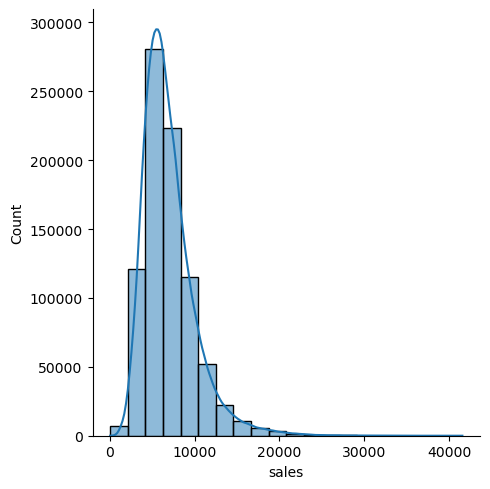

In [32]:
sns.displot(df4['sales'], bins=20, kde=True)
#sns.barplot(x=["A", "B", "C"], y=[1, 3, 2])


### Numerical Variables

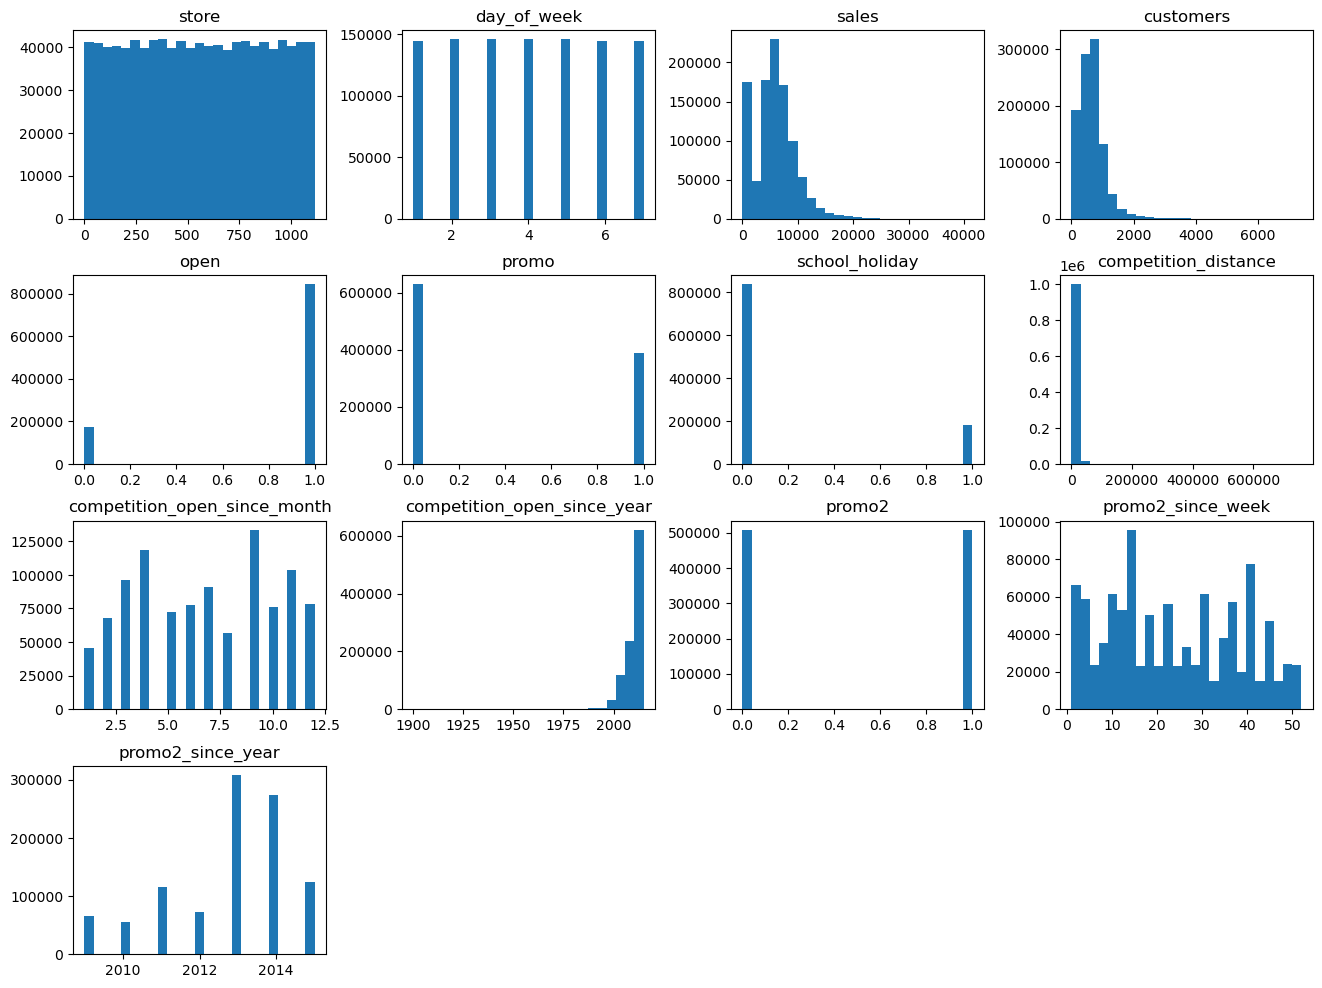

In [33]:
num_attributes.hist(bins=25, grid=False, figsize=(16,12));

### Categorical Variables

In [34]:
df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


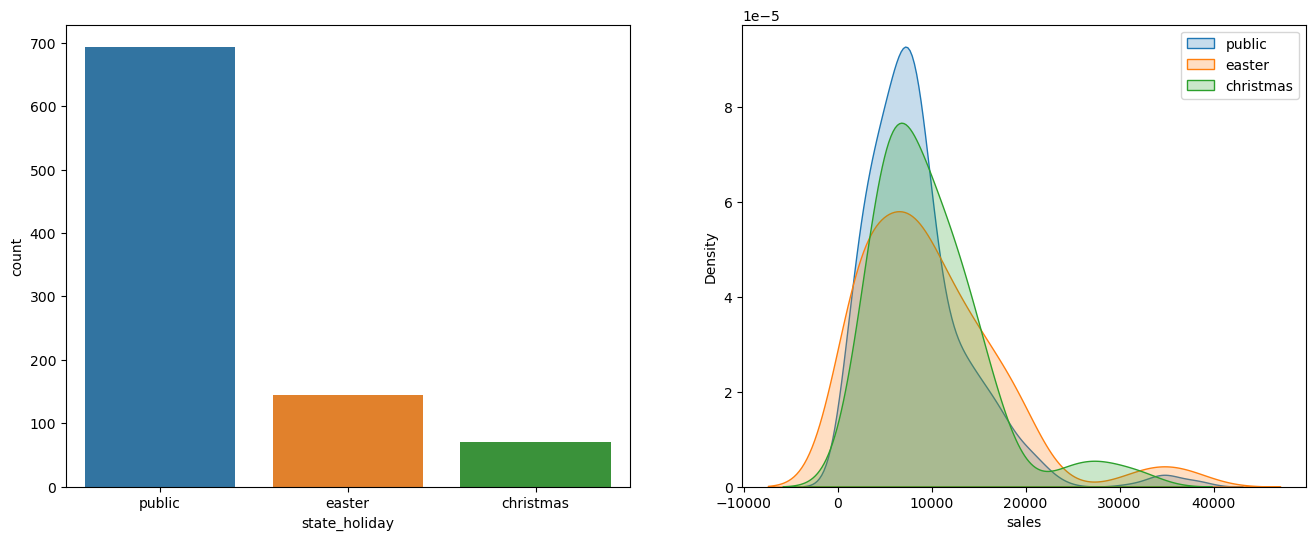

In [35]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
df_aux = df4[df4['state_holiday'] != 'regular']
sns.countplot(df_aux['state_holiday'])
plt.subplot(1, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public']['sales'], label='public', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter']['sales'], label='easter', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()

/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


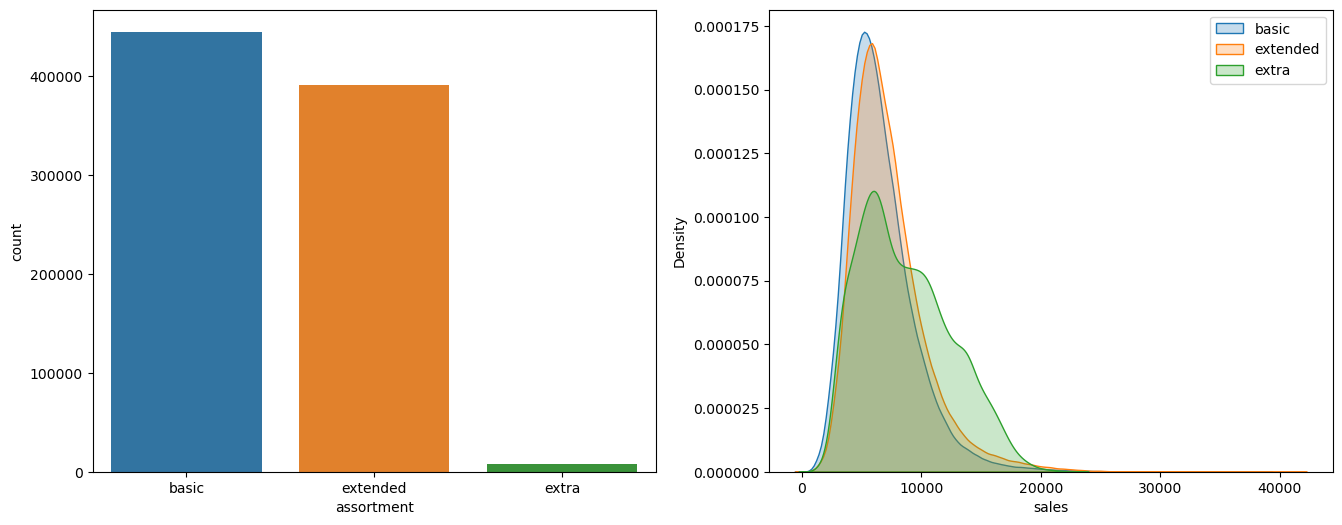

In [36]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.countplot(df4['assortment'])
plt.subplot(1, 2, 2)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()

/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


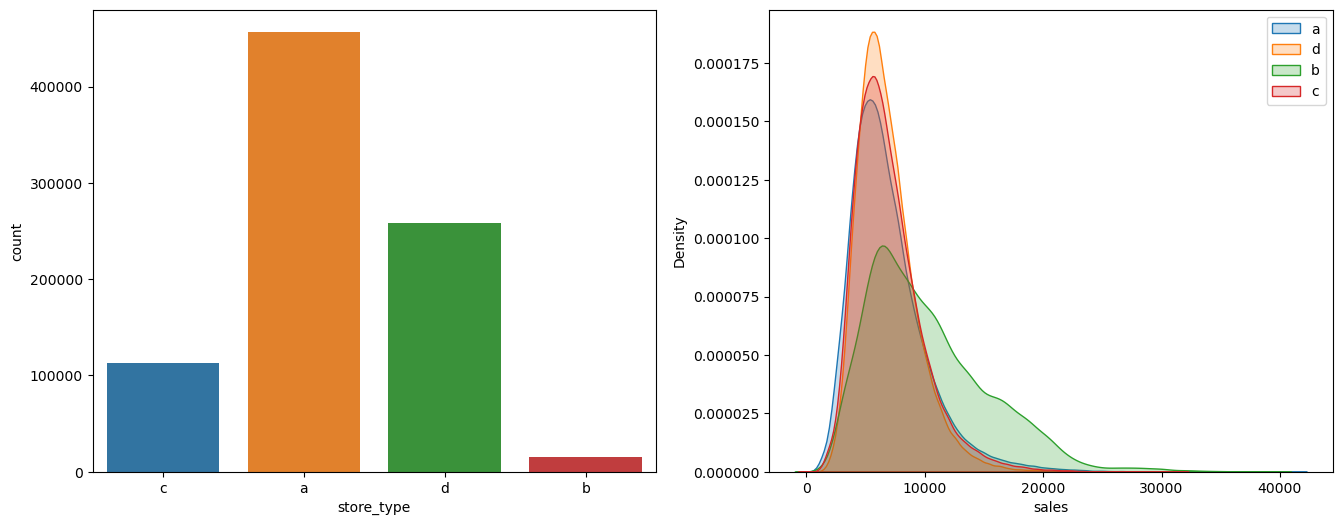

In [37]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.countplot(df4['store_type'])
plt.subplot(1, 2, 2)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
plt.legend()

## Bivariate Analysis

### H1 - Lojas com maiores sortimentos deveriam vender mais  
Falsa, Conforme os gráficos abaixo, lojas com assortment 'extra' possuem volumes de vendas menores

<AxesSubplot:xlabel='assortment', ylabel='sales'>

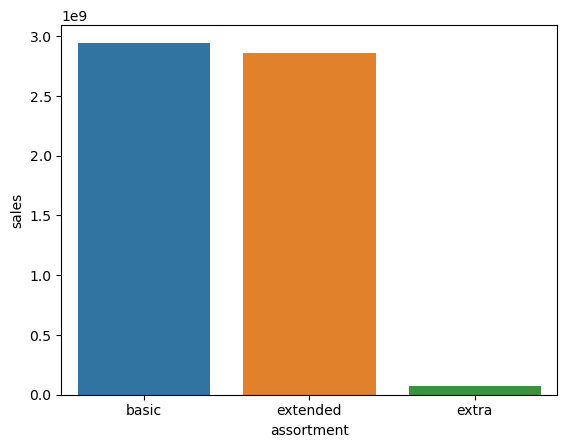

In [38]:
df_aux = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x=df_aux['assortment'], y=df_aux['sales'])

<AxesSubplot:xlabel='year_week'>

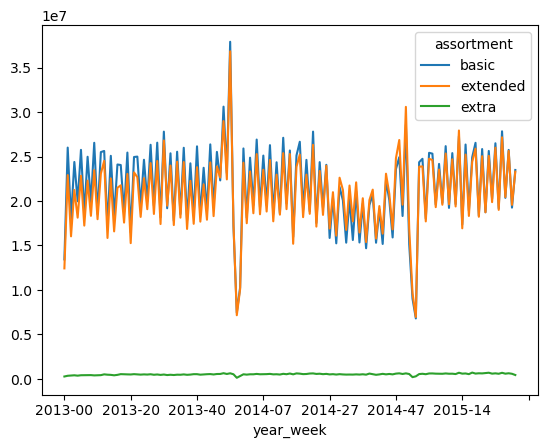

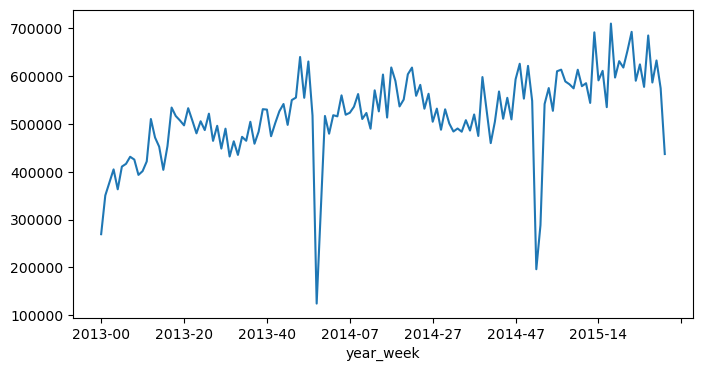

In [39]:
df_aux = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
df_aux = df_aux.pivot(index='year_week', columns='assortment', values='sales')
#plt.figure(figsize=(16,6))
#plt.subplot(2,1,1)
df_aux.plot()
#plt.subplot(2,1,2)
plt.figure(figsize=(8,4))
df_aux['extra'].plot()

### H2 - Lojas com competidores mais próximos deveriam vender menos  
Falso, conforme abaixo, lojas com competidores mais próximos vendem mais

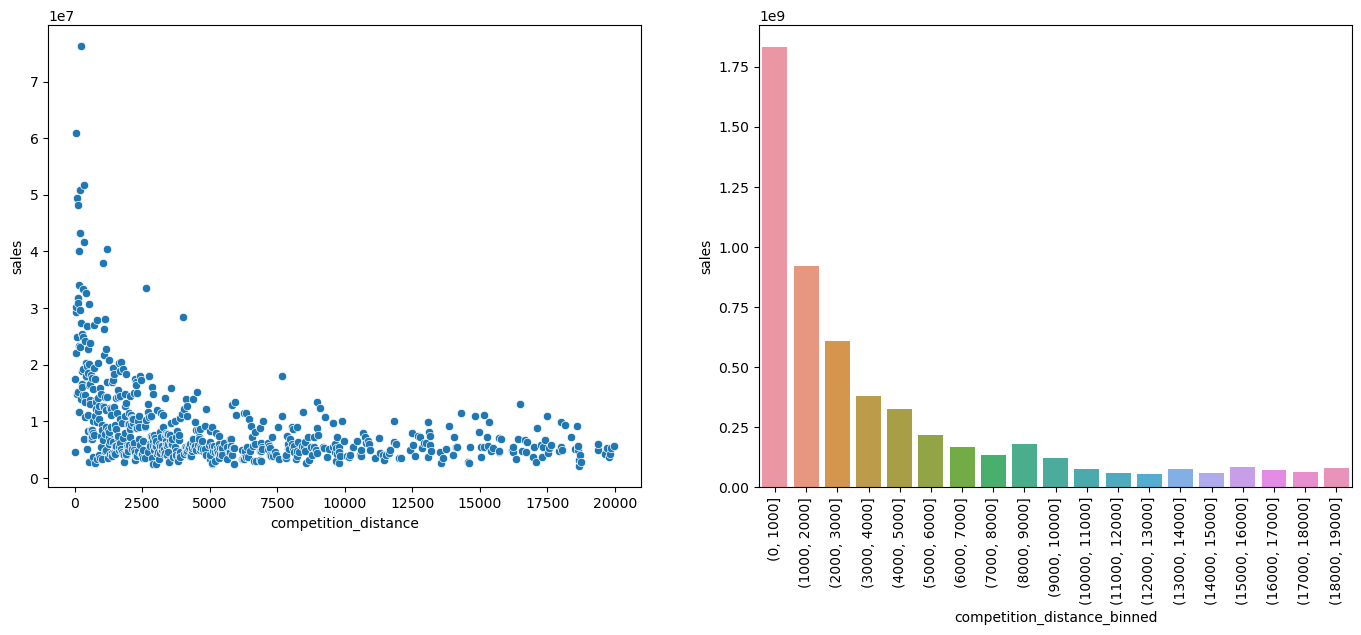

In [40]:
plt.figure(figsize=(26,6))
plt.subplot(1, 3, 1)
df_aux = df4[df4['competition_distance'] < 20000]
df_aux = df_aux[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x=df_aux['competition_distance'], y=df_aux['sales'])
df_aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))
df_aux['competition_distance_binned'] = pd.cut(df_aux['competition_distance'], bins=bins)
df_aux = df_aux[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1, 3, 2)
sns.barplot(x=df_aux['competition_distance_binned'], y=df_aux['sales'])
plt.xticks(rotation=90);

### H3 - Lojas com competidores a mais tempo deveriam vender mais  
False. Lojas com COMPETIDORES a mais tempo vendem MENOS


<AxesSubplot:>

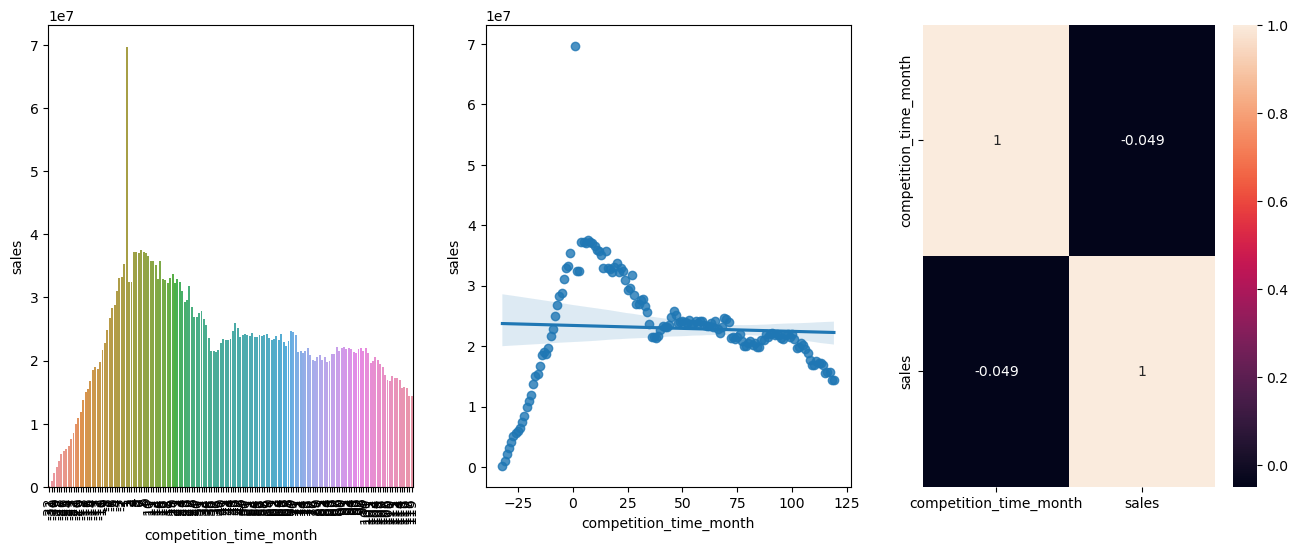

In [41]:
df_aux = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
df_aux = df_aux[(df_aux['competition_time_month'] != 0) & (df_aux['competition_time_month'] < 120)]
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
sns.barplot(x=df_aux['competition_time_month'], y=df_aux['sales'])
plt.xticks(rotation=90);
plt.subplot(1, 3, 2)
sns.regplot(x=df_aux['competition_time_month'], y=df_aux['sales'])
plt.subplot(1, 3, 3)
sns.heatmap(df_aux.corr(method='pearson'), annot=True)

### H4 - Lojas com promoções ativas por mais tempo deveriam vender mais  
Falso. Lojas com promoções ativas por mais tempo vendem menos depois de um certo tempo. 

<AxesSubplot:>

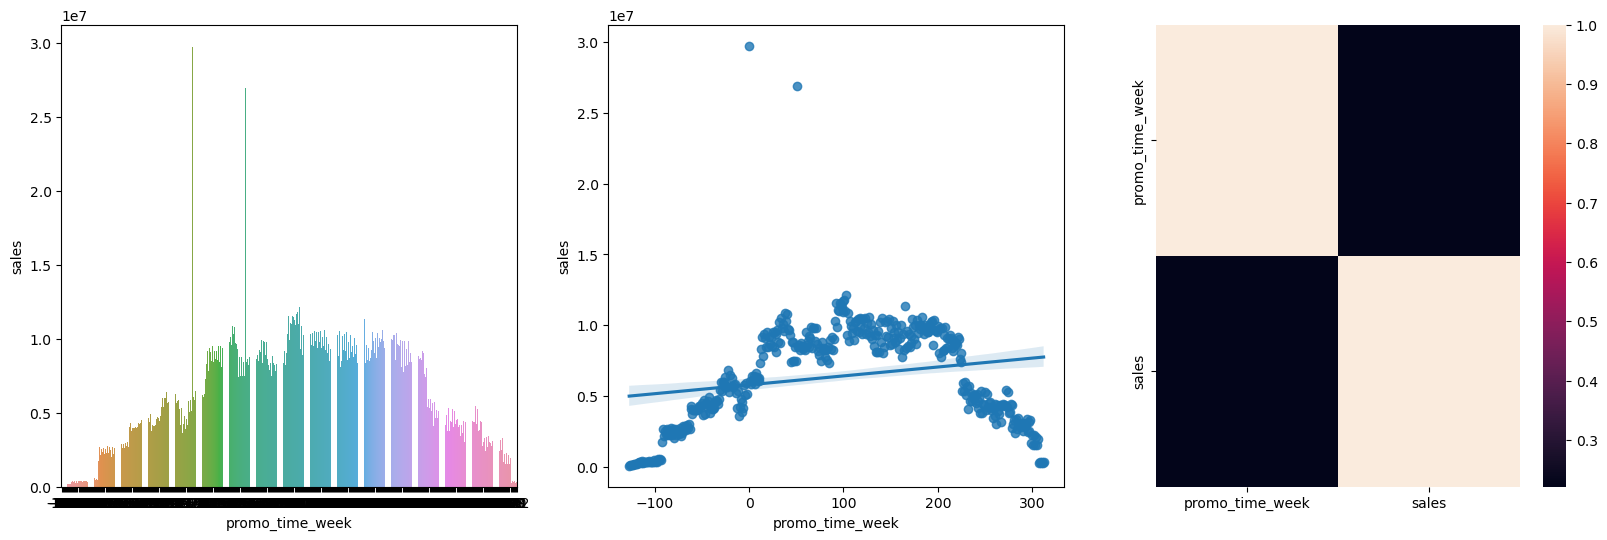

In [42]:
df_aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
df_aux = df_aux[df_aux['promo_time_week'] != -1]
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
sns.barplot(x='promo_time_week', y='sales', data=df_aux)
plt.subplot(1, 3, 2)
sns.regplot(x='promo_time_week', y='sales', data=df_aux)
plt.subplot(1, 3, 3)
sns.heatmap(df_aux.corr(method='pearson'))

In [43]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'in_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### <s>H5 - Lojas com mais dias de promoção deveriam vender mais</s>


### H6 - Lojas com mais promoções consecutivas deveriam vender mais  
Falso, lojas com promoções extendidas vendem menos


In [44]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


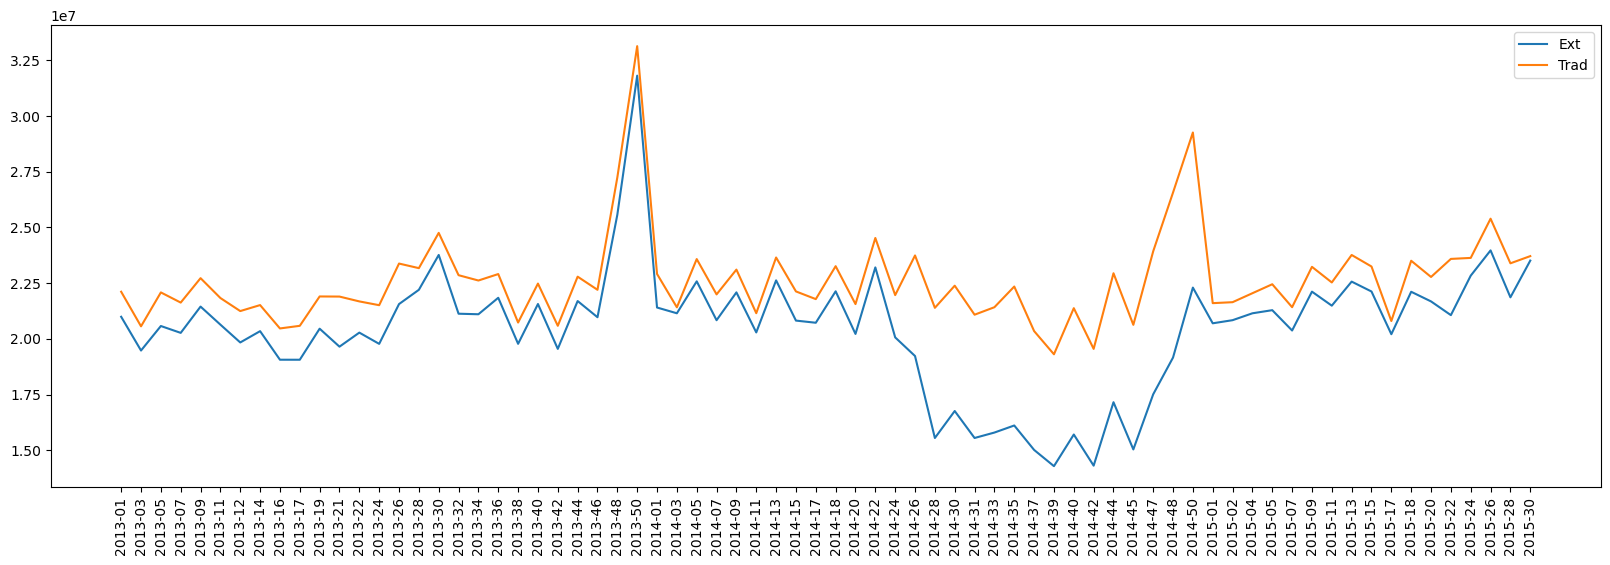

In [45]:
df_aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
plt.figure(figsize=(20,6))
plt.plot(df_aux1['year_week'], df_aux1['sales'], label='Ext')

df_aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
plt.plot(df_aux2['year_week'], df_aux2['sales'], label='Trad')

plt.legend()
plt.xticks(rotation=90);

### H7 - Lojas abertas durante o feriado de natal deveriam vender mais  
Comparadas a

<AxesSubplot:xlabel='year', ylabel='sales'>

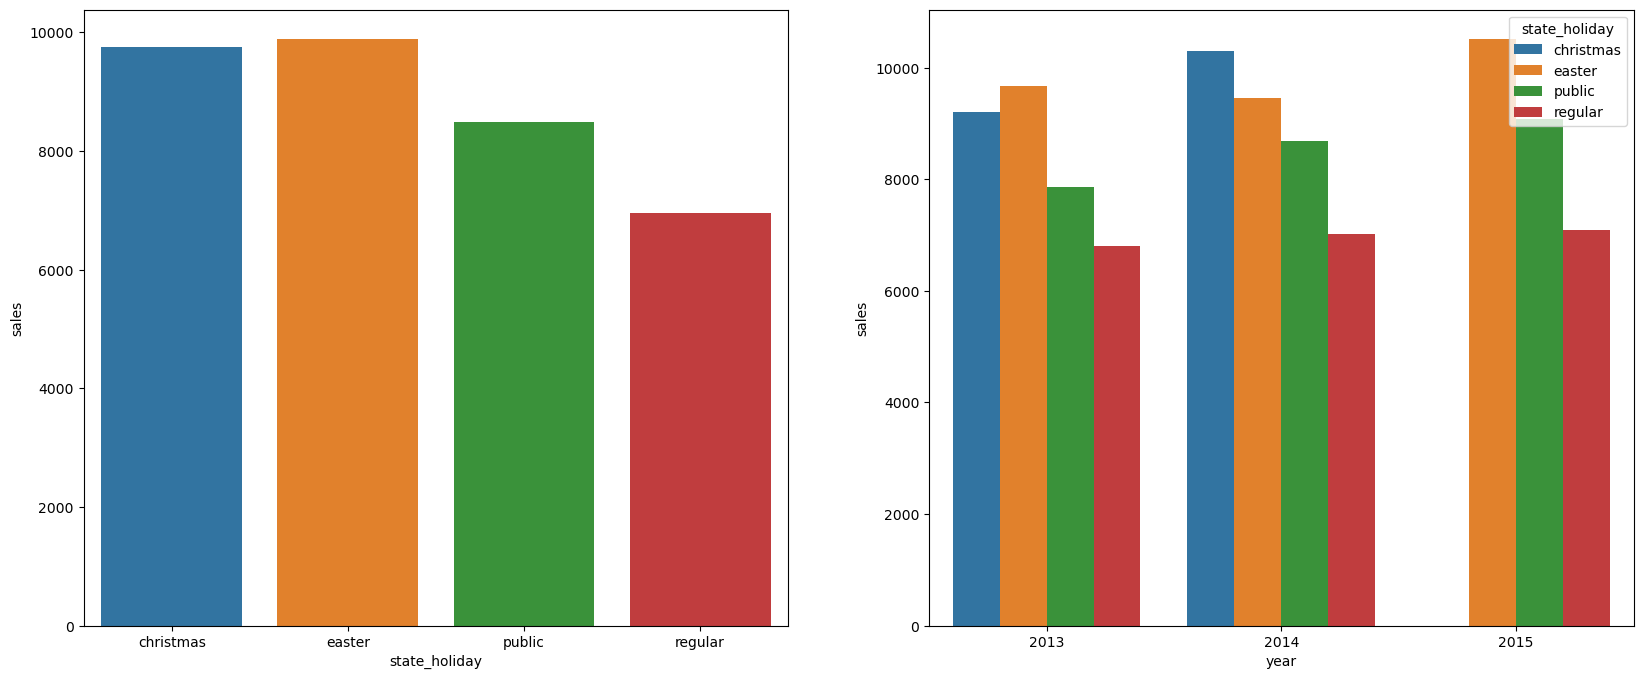

In [46]:
df_aux = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.barplot(x=df_aux['state_holiday'], y=df_aux['sales'])

plt.subplot(1, 2, 2)
df_aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=df_aux2)

### H8 - Lojas deveriam vender mais ao longo dos anos  
Falsa, as vendas aparentam estar caindo. Apensa dos dados para 2015 estarem imcompletos

<AxesSubplot:>

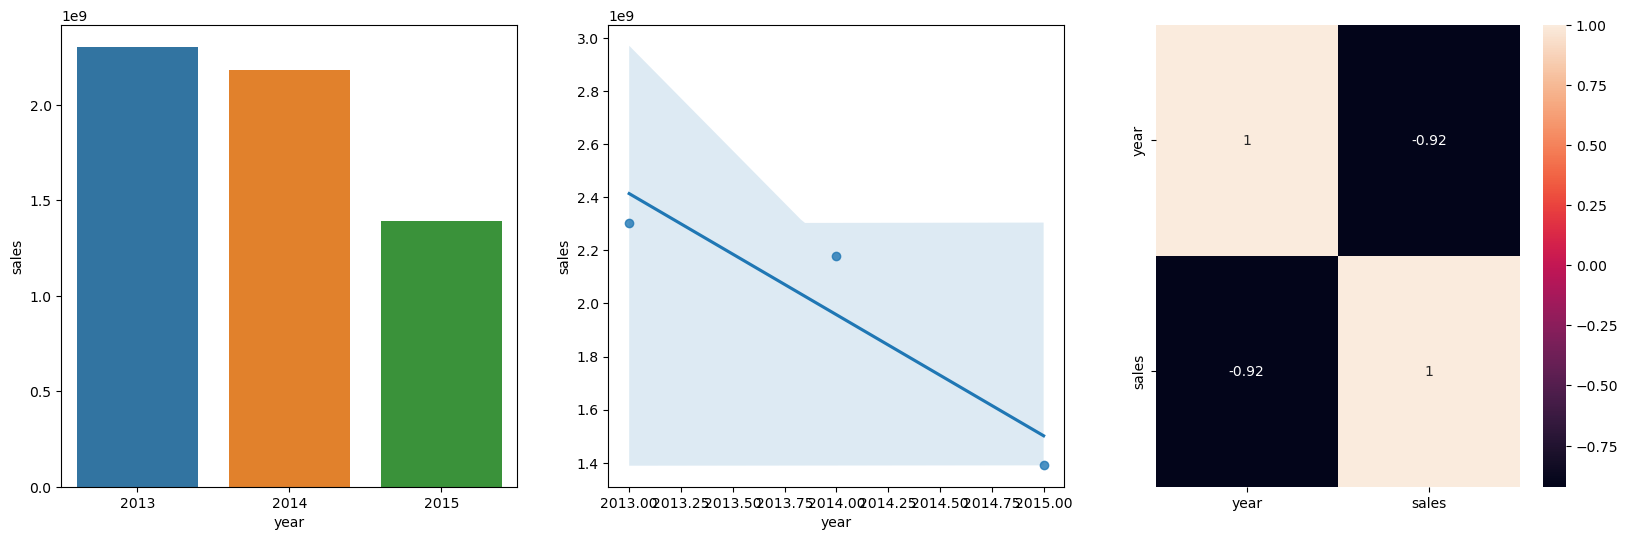

In [47]:
df_aux = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=df_aux)
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=df_aux)
plt.subplot(1, 3, 3)
sns.heatmap(df_aux.corr(method='pearson'), annot=True)

### H9 - Lojas deveriam vender mais no segundo semestre do ano  
A principio falsa, porque lojas vendem menos no segundo semestre do ano.
Acho que essa diferença esta se dando por causa do range de dados.

<AxesSubplot:>

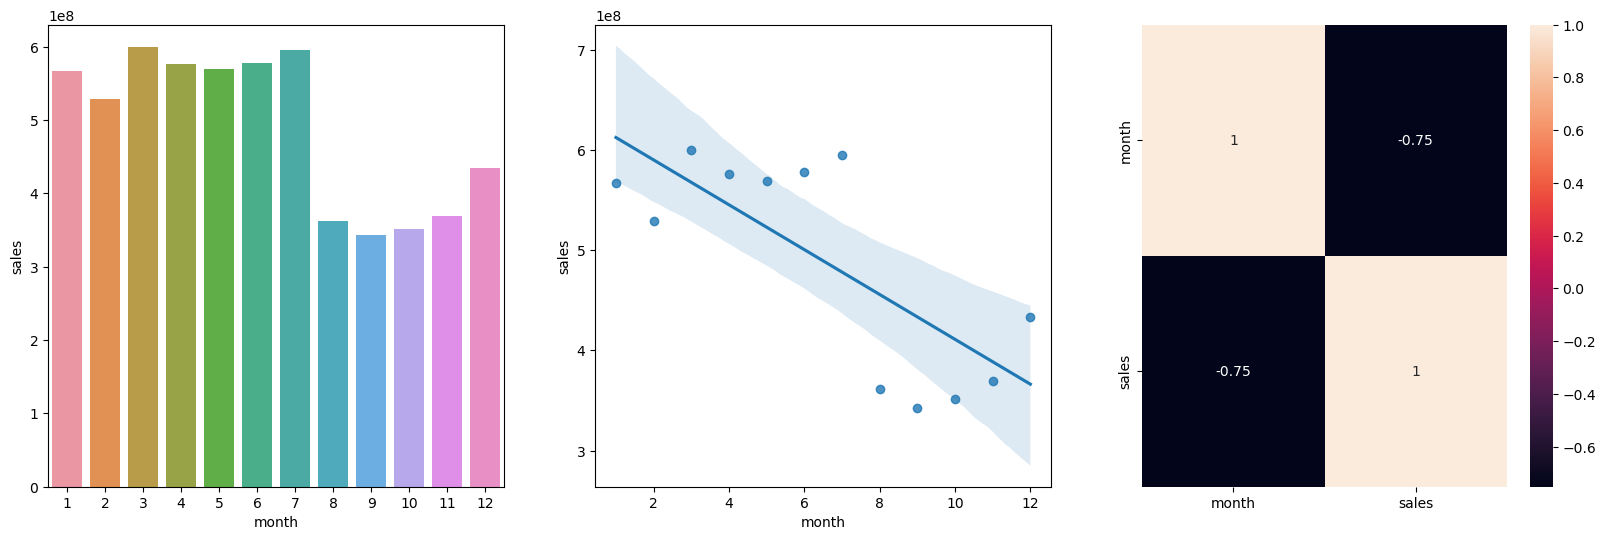

In [48]:
df_aux = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=df_aux)
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=df_aux)
plt.subplot(1, 3, 3)
sns.heatmap(df_aux.corr(method='pearson'), annot=True)

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês  
Sim, as vendas caem até o dia 10 depois começam a subir até o dia 15 caem até 25 e voltam a subir

<AxesSubplot:>

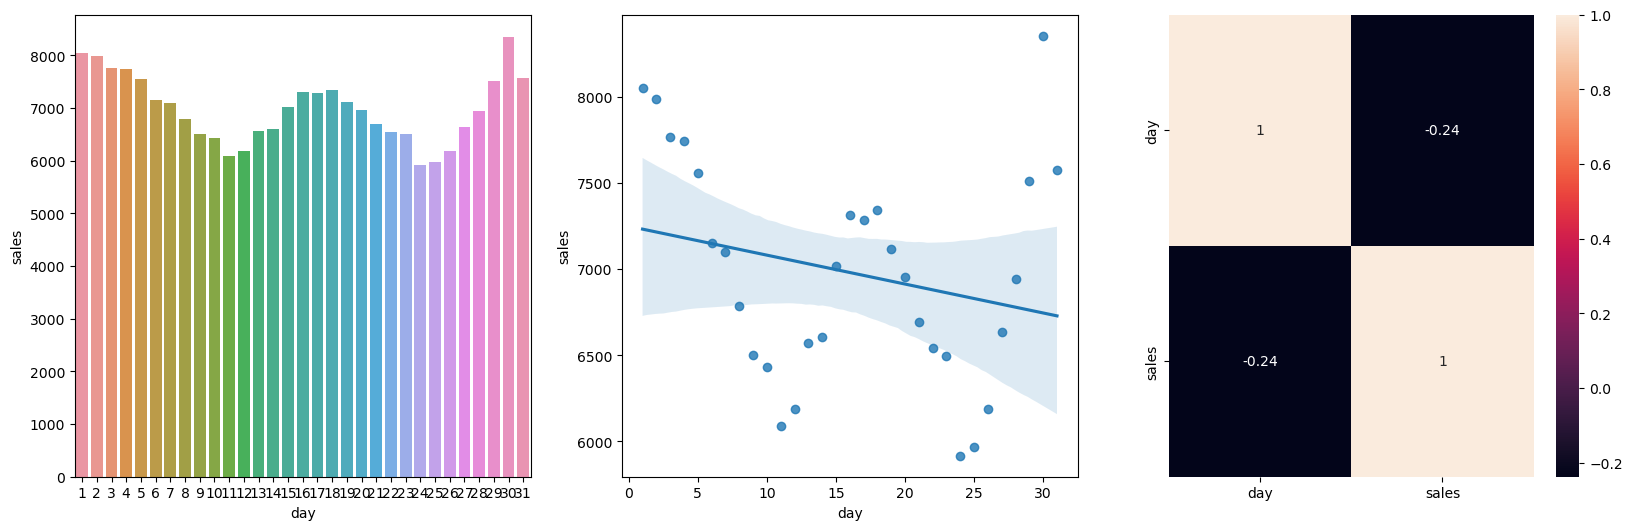

In [49]:
df_aux = df4[['day', 'sales']].groupby('day').mean().reset_index()
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='day', y='sales', data=df_aux)
plt.subplot(1, 3, 2)
sns.regplot(x='day', y='sales', data=df_aux)
plt.subplot(1, 3, 3)
sns.heatmap(df_aux.corr(method='pearson'), annot=True)

### H11 - Lojas deveriam vender menos aos finais de semana  
Sim, lojas vendem menos nos finais de semana
Apesar de a média para os domingos se alta. Isso quer pode significar que para os domingos que são abertos a média de vendas é alta.

<AxesSubplot:>

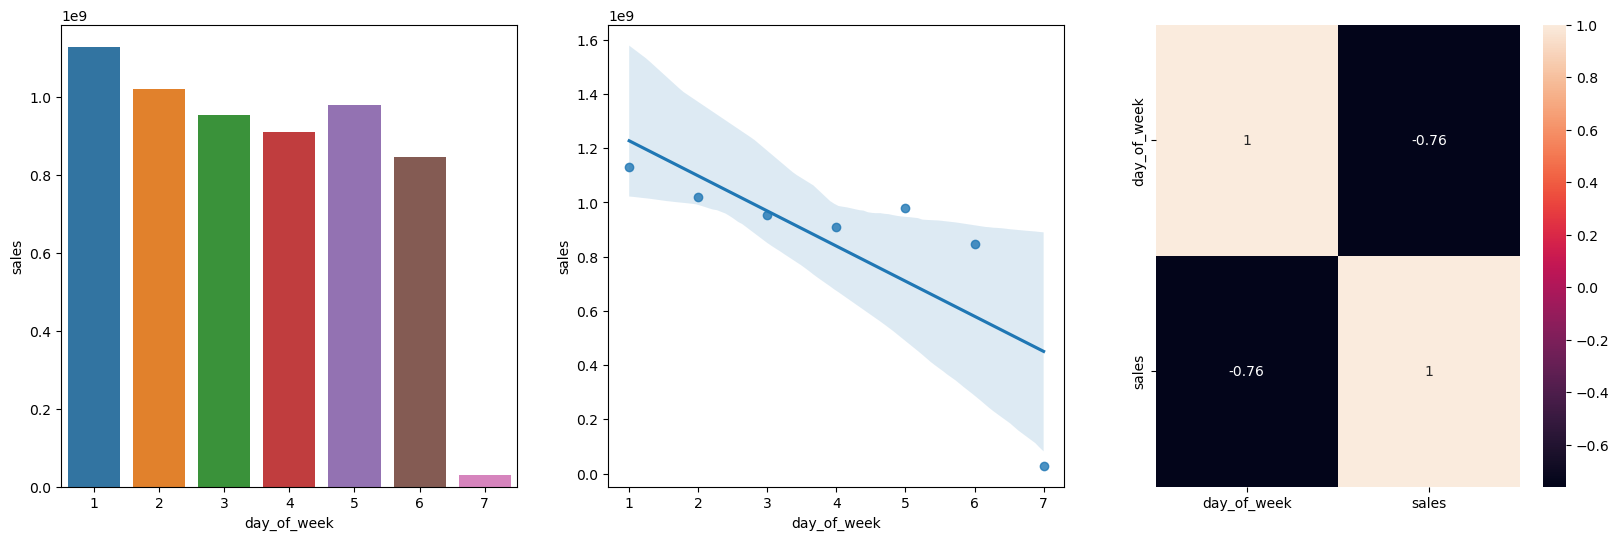

In [50]:
df_aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=df_aux)
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=df_aux)
plt.subplot(1, 3, 3)
sns.heatmap(df_aux.corr(method='pearson'), annot=True)

### H12 - Lojas deveriam vender menos durante os feriados escolares  
Sim, exceto nos periodos de feriados escolares

<AxesSubplot:xlabel='month', ylabel='sales'>

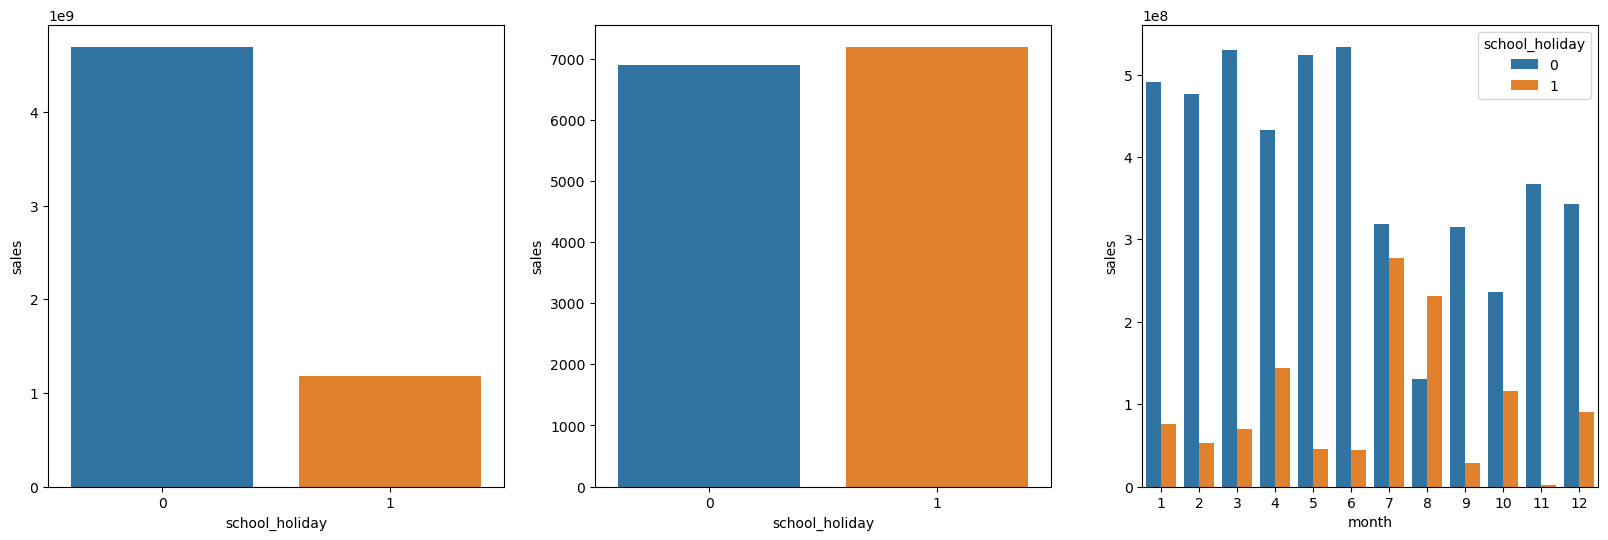

In [51]:
plt.figure(figsize=(20, 6))
df_aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='school_holiday', y='sales', data=df_aux)
df_aux = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
plt.subplot(1, 3, 2)
sns.barplot(x='school_holiday', y='sales', data=df_aux)
df_aux = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(1, 3, 3)
sns.barplot(x='month', y='sales', hue='school_holiday', data=df_aux)

## Multivariate Analysis

### Numerical Attributes

<AxesSubplot:>

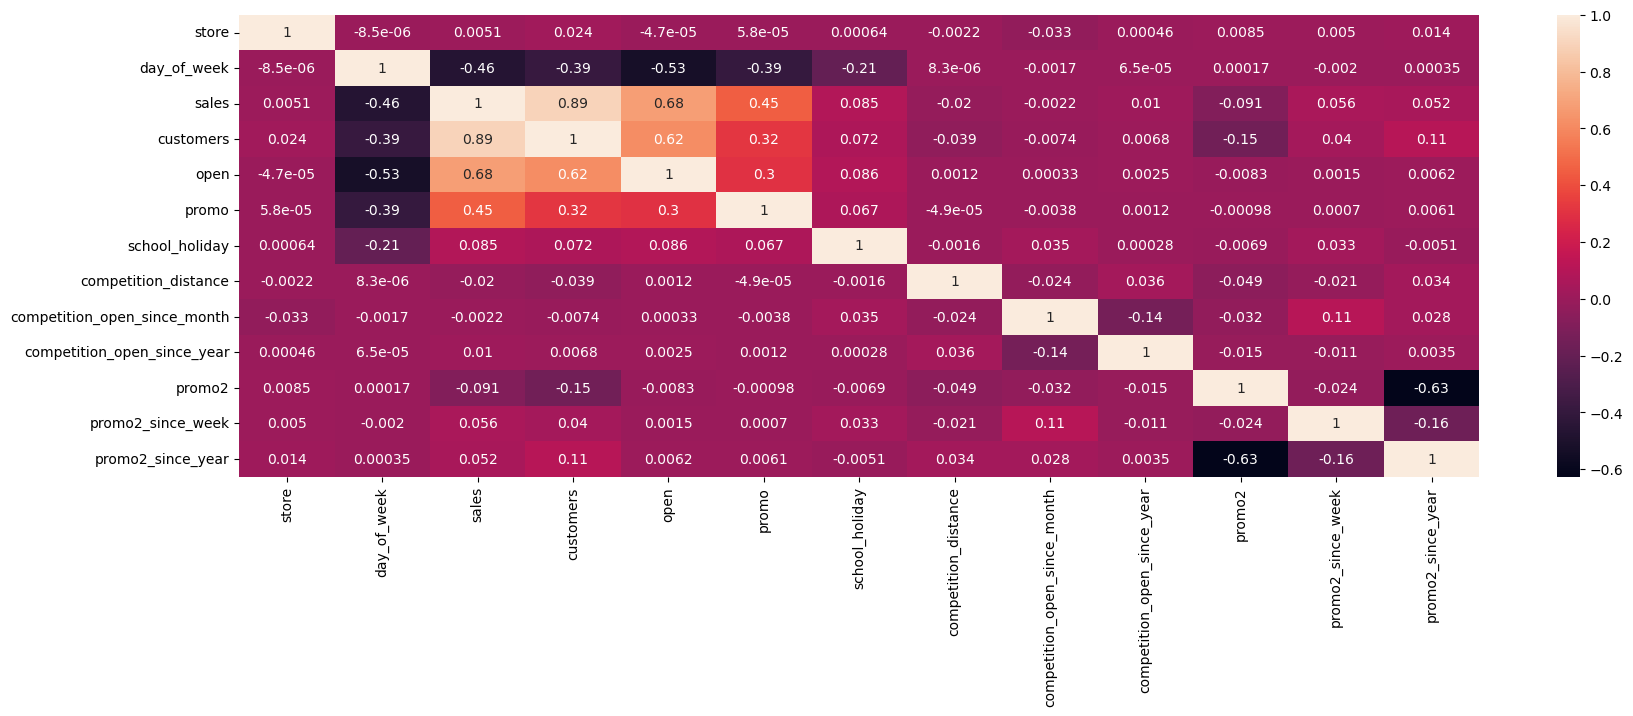

In [52]:
correlations = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,6))
sns.heatmap(correlations, annot=True)

### Categorical Attributes

In [53]:
cat_attributes = df4.select_dtypes(include=['object'])
cat_attributes 

,state_holiday,store_type,assortment,year_week
0,regular,c,basic,2015-30
1,regular,a,basic,2015-30
2,regular,a,basic,2015-30
3,regular,c,extended,2015-30
4,regular,a,basic,2015-30
...,...,...,...,...
1016776,public,b,basic,2013-00
1016827,public,b,extra,2013-00
1016863,public,b,extra,2013-00
1017042,public,b,extra,2013-00


In [54]:
correlations = pd.crosstab(cat_attributes.columns, cat_attributes.columns)

for column in correlations.columns:
    for row in correlations.index:
        correlations.loc[row, column] = cramer_v(cat_attributes[row], cat_attributes[column])

correlations


col_0,assortment,state_holiday,store_type,year_week
row_0,,,,
assortment,1.000001,0.067546,0.538457,0.013168
state_holiday,0.067546,1.000002,0.071065,0.083470
store_type,0.538457,0.071065,1.000002,0.015270
year_week,0.013168,0.083470,0.015270,1.000081


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

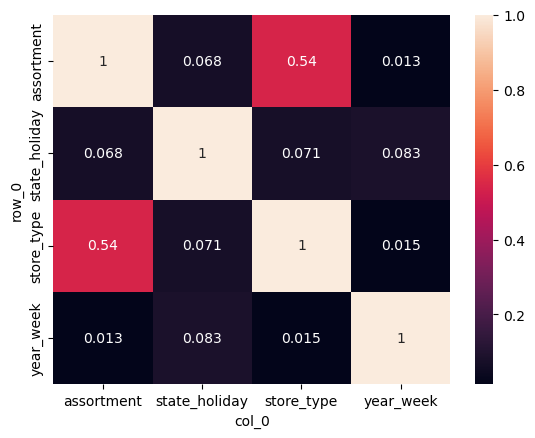

In [55]:
sns.heatmap(correlations, annot=True)

# Data Preparation

In [202]:
df5 = df4.copy()

## Normalization

In [203]:
#Não será normalizada nenhum feature pois nenhuma possui distrubuição normal

## Rescaling

In [204]:
rs = RobustScaler()
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('/home/biazotogabriel/repos/courses/ds_em_producao/parameter/competition_distance_rescaler.pkl', 'wb'))


In [205]:
# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('/home/biazotogabriel/repos/courses/ds_em_producao/parameter/competition_time_month_rescaler.pkl', 'wb'))


In [206]:
mms = MinMaxScaler()
# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('/home/biazotogabriel/repos/courses/ds_em_producao/parameter/promo_time_week_rescaler.pkl', 'wb'))


In [207]:
# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('/home/biazotogabriel/repos/courses/ds_em_producao/parameter/year_rescaler.pkl', 'wb'))

## Transformation

### Enconding

In [208]:
# state_holiday One Hot Enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [209]:
# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/home/biazotogabriel/repos/courses/ds_em_producao/parameter/store_type_label_encoder.pkl', 'wb'))


In [210]:
# assortment
oe = OrdinalEncoder(dtype='int64', categories=[['basic', 'extra', 'extended']])
df5['assortment'] = oe.fit_transform(df5[['assortment']].values)
pickle.dump(oe, open('/home/biazotogabriel/repos/courses/ds_em_producao/parameter/assortment_ordinal_encoder.pkl', 'wb'))

In [40]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter,state_holiday_public,state_holiday_regular
0,1,5,2015-07-31,5263,1,1,2,0,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-08-02,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,0,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-28,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,0,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-04-03,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,2,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-08-02,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,0,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-08-02,0.287016,0,0,0,1


### Response Variable

In [41]:
df5['sales'] = np.log1p(df5['sales'])

/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

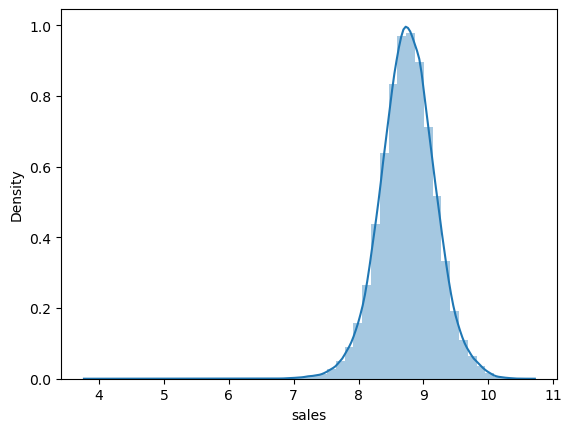

In [42]:
sns.distplot(df5['sales'])

### Nature

In [43]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. *  np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. *  np.pi / 7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. *  np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. *  np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. *  np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. *  np.pi / 30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. *  np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. *  np.pi / 52)))

In [44]:
df5.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public,state_holiday_regular,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
358887,26,5,2014-08-22,8.945202,1,1,3,0,-0.004839,8,...,0,1,-0.974928,-0.222521,-8.660254e-01,-5.000000e-01,-9.945219e-01,-0.104528,-0.822984,-5.680647e-01
46904,75,5,2015-06-19,8.801168,1,0,3,2,3.243548,12,...,0,1,-0.974928,-0.222521,1.224647e-16,-1.000000e+00,-7.431448e-01,-0.669131,0.120537,-9.927089e-01
806519,45,1,2013-07-08,8.558719,0,1,3,0,1.190323,2,...,0,1,0.781831,0.623490,-5.000000e-01,-8.660254e-01,9.945219e-01,-0.104528,-0.239316,-9.709418e-01
924337,788,1,2013-03-25,10.066754,1,1,0,2,-0.129032,3,...,0,1,0.781831,0.623490,1.000000e+00,6.123234e-17,-8.660254e-01,0.500000,1.000000,6.123234e-17
120233,929,3,2015-04-15,8.643297,1,1,0,2,0.401613,9,...,0,1,0.433884,-0.900969,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000,0.935016,-3.546049e-01


# Features Selection

In [45]:
df6 = df5.copy()

## Split Dataframe

In [46]:
df6.columns
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(columns=cols_drop)
df6.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'in_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas', 'state_holiday_easter',
       'state_holiday_public', 'state_holiday_regular', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'week_of_year_sin', 'week_of_year_cos'],
      dtype='object')

In [47]:
spliter_date = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - timedelta(weeks=6)

In [48]:
X_train = df6.loc[df6['date'] < spliter_date]
y_train = df6.loc[df6['date'] < spliter_date, 'sales']

X_test = df6.loc[df6['date'] >= spliter_date]
y_test = df6.loc[df6['date'] >= spliter_date, 'sales']

In [49]:
print('Train data range from {} to {}'.format(X_train['date'].min().strftime(r'%d-%m-%Y'), X_train['date'].max().strftime(r'%d-%m-%Y')))
print('Test data range from {} to {}'.format(X_test['date'].min().strftime(r'%d-%m-%Y'), X_test['date'].max().strftime(r'%d-%m-%Y')))

Train data range from 01-01-2013 to 18-06-2015
Test data range from 19-06-2015 to 31-07-2015


## Boruta as Feature Selector

In [50]:
rf = RandomForestRegressor(n_jobs=-1)

X_train_n = X_train.drop(columns=['date']).values
y_train_n = y_train.values.ravel()

In [51]:
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

KeyboardInterrupt: 

In [ ]:
cols_selected = list(boruta.support_)

# best features
X_train_fs = X_train.drop(columns='date')
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns

cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [258]:
#Final cols selected according with boruta
selected = [
    'store', 
    'promo', 
    'store_type', 
    'assortment', 
    'competition_distance',
    'competition_open_since_month', 
    'competition_open_since_year', 
    'promo2',
    'promo2_since_week', 
    'promo2_since_year', 
    'competition_time_month',
    'promo_time_week', 
    'day_of_week_sin', 
    'day_of_week_cos', 
    'month_sin',
    'month_cos',
    'day_sin', 
    'day_cos',
    'week_of_year_sin', 
    'week_of_year_cos'] 

feature_add = ['date', 'sales']
selected.extend(feature_add)
selected

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# Machine Learning Modeling

In [259]:
x_train = X_train[selected].drop(columns=['date', 'sales'])
x_test = X_test[selected].drop(columns=['date', 'sales'])
x_training = X_train[selected]

## Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test

# predction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = aux1.merge(aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))

In [ ]:
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## Linear Regression Model

In [ ]:
x_train.columns

Index(['store', 'promo', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'sales'],
      dtype='object')

In [245]:
x_train = X_train.drop(columns=['sales', 'date'])
x_test = X_test.drop(columns=['sales', 'date'])

In [246]:
# model
lr = LinearRegression()

# fit
lr.fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1860.269238,0.285708,2690.376341


In [244]:
x_test.columns

Index(['store', 'promo', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'sales'],
      dtype='object')

In [ ]:
# cross validation
lr_metrics, lr_summary = cross_validation(lr, x_training, 5)
lr_summary

,method,mean,std
0,MAE,1993.291178,46.577088
1,MAPE,0.294505,0.010960
2,RMSE,2851.977879,97.846921


## Linear Regression Regularized Model

In [ ]:
# model
lrr = Lasso(alpha=0.01)

# fit
lrr.fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1890.157813,0.28896,2745.550239


In [ ]:
# cross validation
lrr_metrics, lrr_summary = cross_validation(lrr, x_training, 5)
lrr_summary

,method,mean,std
0,MAE,2036.679914,60.427213
1,MAPE,0.285471,0.003668
2,RMSE,2968.032813,100.277929


## Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

rf.fit(x_train, y_train)

yhat_rf = rf.predict(x_test)

rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))

In [ ]:
# cross validation
rf_metrics, rf_summary = cross_validation(rf, x_training, 5, True)
rf_summary

## XGBoost Regressor

In [56]:
xgb = XGBRegressor(objective='reg:squarederror',
                   n_estimators=100,
                   eta=0.3,
                   max_depth=6,
                   subsample=1,
                   colsample_bytree=1)

xgb.fit(x_train, y_train)

yhat_xgb = xgb.predict(x_test)

xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))

In [57]:
# cross validation
xgb_metrics, xgb_summary = cross_validation(xgb, x_training, 5, True)
xgb_summary

KFold nr: 5
KFold nr: 4
KFold nr: 3
KFold nr: 2
KFold nr: 1


,method,mean,std
0,MAE,1059.721499,86.104355
1,MAPE,0.146017,0.012037
2,RMSE,1524.677199,124.726790


## Compare Performance with Cross Validation

In [112]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result]).sort_values('RMSE')
modelling_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,664.291898,0.098328,991.052566
0,XGBoost Regressor,901.592132,0.136192,1286.056310
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1860.269238,0.285708,2690.376341
0,Linear Regression - Lasso,1890.157813,0.288960,2745.550239


In [92]:
# cross validation
pd.concat([lr_summary, lrr_summary, xgb_summary])
# Apesar da RandomFOrest Ter melhor resultado, será seuido com a xgb
# Isso porque possui menos conteudo na internet e também devido o xgb geralmente gerar modelos menores (requerem menos hd para funcionar)
'''
	method	mean	std
0	MAE	1993.291178	46.577088
1	MAPE	0.294505	0.010960
2	RMSE	2851.977879	97.846921
0	MAE	2036.679914	60.427213
1	MAPE	0.285471	0.003668
2	RMSE	2968.032813	100.277929
0	MAE	1059.721499	86.104355
1	MAPE	0.146017	0.012037
2	RMSE	1524.677199	124.726790
'''


,method,mean,std
0,MAE,1993.291178,46.577088
1,MAPE,0.294505,0.010960
2,RMSE,2851.977879,97.846921
0,MAE,2036.679914,60.427213
1,MAPE,0.285471,0.003668
2,RMSE,2968.032813,100.277929
0,MAE,1059.721499,86.104355
1,MAPE,0.146017,0.012037
2,RMSE,1524.677199,124.726790


# Hyperparameter Fine Tuning

## Random Search

In [71]:
param = {
    'n_estimators': [150, 250, 350, 1500, 2500, 3500],
    'eta': [0.01, 0.03, 0.1, 0.3],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_wight': [3, 8, 15]
}

MAX_EVAL = 10

In [72]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    xgb = XGBRegressor(objective='reg:squarederror',
                       n_estimators=hp['n_estimators'],
                       eta=hp['eta'],
                       max_depth=hp['max_depth'],
                       subsample=hp['subsample'],
                       colsample_bytree=hp['colsample_bytree'],
                       min_child_weight=hp['min_child_wight'])

    result_d, result_s = cross_validation(xgb, x_training, 5)
    final_result = pd.concat([final_result, result_s], axis=1)
final_result

{'n_estimators': 250, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_wight': 8}
{'n_estimators': 150, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_wight': 15}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_wight': 15}
{'n_estimators': 150, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_wight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_wight': 15}
{'n_estimators': 250, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_wight': 15}
{'n_estimators': 350, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_wight': 8}
{'n_estimators': 1500, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_wight': 15}
{'n_estimators': 1500, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.1

,method,mean,std,method,mean,std,method,mean,std,method,...,std,method,mean,std,method,mean,std,method,mean,std
0,MAE,1715.298220,42.860236,MAE,1578.061956,38.334350,MAE,1252.229914,83.698009,MAE,...,36.993408,MAE,1151.053169,101.937086,MAE,1030.818310,112.865858,MAE,4025.157474,103.627503
1,MAPE,0.237871,0.005114,MAPE,0.217275,0.004156,MAPE,0.171835,0.009109,MAPE,...,0.003807,MAPE,0.158652,0.011457,MAPE,0.143164,0.014875,MAPE,0.496565,0.005715
2,RMSE,2480.966774,59.905374,RMSE,2291.028641,65.414420,RMSE,1817.691299,120.446319,RMSE,...,53.792194,RMSE,1650.767074,147.731913,RMSE,1466.992587,166.318420,RMSE,4932.904949,120.251190


## Final Model

In [263]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.1,
    'colsample_bytree': 0.3,
    'min_child_wight': 8 
}

xgb = XGBRegressor(objective='reg:squarederror',
                    n_estimators=param_tuned['n_estimators'],
                    eta=param_tuned['eta'],
                    max_depth=param_tuned['max_depth'],
                    subsample=param_tuned['subsample'],
                    colsample_bytree=param_tuned['colsample_bytree'],
                    min_child_weight=param_tuned['min_child_wight'])
                    
xgb.fit(x_train, y_train)

yhat_xgb = xgb.predict(x_test)

xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,780.9873,0.117665,1114.175685


In [249]:
mean_percented_error(np.expm1(y_test), np.expm1(yhat_xgb))

-0.025660269365928388

# Tradução e Interpretação do Erro

In [98]:
df7 = X_test[selected].copy()
df7['sales'] = np.expm1(df7['sales'])
df7['predictions'] = np.expm1(yhat_xgb)

## Business Performance

In [164]:
business = (df7.loc[:, ['store', 'sales', 'predictions']]
               .groupby('store')
               .agg(**{
                'predictions': ('predictions', 'sum'),
                'mae': ('sales', lambda x: mt.mean_absolute_error(x, df7.loc[list(x.index), 'predictions'])),
                'mape': ('sales', lambda x: mean_absolute_percentage_error(x, df7.loc[list(x.index), 'predictions']))
               })
               .reset_index()
               .assign(worst_scenario=lambda x: x['predictions'] - x['mae'],
                       best_scenario=lambda x: x['predictions'] + x['mae']))
               
business

,store,predictions,mae,mape,worst_scenario,best_scenario
0,1,162196.953125,27.385089,0.006468,162169.568036,162224.338214
1,2,183120.171875,35.957223,0.007157,183084.214652,183156.129098
2,3,255168.578125,54.795509,0.007498,255113.782616,255223.373634
3,4,367488.687500,63.359045,0.006526,367425.328455,367552.046545
4,5,167564.312500,33.659939,0.007485,167530.652561,167597.972439
...,...,...,...,...,...,...
1110,1111,174179.953125,42.026453,0.009227,174137.926672,174221.979578
1111,1112,319267.031250,55.717391,0.006711,319211.313859,319322.748641
1112,1113,243633.187500,31.171875,0.005245,243602.015625,243664.359375
1113,1114,843237.625000,260.588841,0.011057,842977.036159,843498.213841


In [167]:
business.sort_values('mape', ascending=False).head()

,store,predictions,mae,mape,worst_scenario,best_scenario
908,909,343820.781250,809.110001,0.032274,343011.671249,344629.891251
22,23,208267.734375,145.830573,0.027281,208121.903802,208413.564948
826,827,567552.000000,381.215715,0.023840,567170.784285,567933.215715
257,258,211351.453125,139.769399,0.023452,211211.683726,211491.222524
1096,1097,469270.062500,241.940918,0.022723,469028.121582,469512.003418


<AxesSubplot:xlabel='store', ylabel='mape'>

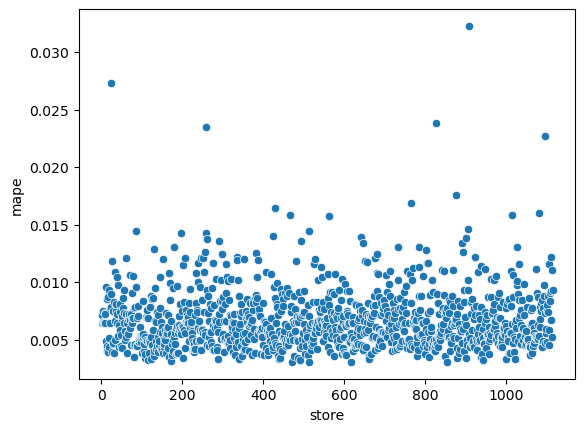

In [168]:
sns.scatterplot(x='store', y='mape', data=business)

## Total Performance

In [183]:
total_business = business[['predictions', 'worst_scenario', 'best_scenario']].sum().to_frame().reset_index()

total_business.columns = ['scenario', 'values']

total_business['values'] = total_business['values'].map('R$ {:,.2f}'.format)

total_business

,scenario,values
0,predictions,"R$ 289,459,520.00"
1,worst_scenario,"R$ 289,405,444.29"
2,best_scenario,"R$ 289,513,597.39"


## Machine Learning Performance

In [186]:
df7['error'] = df7['sales'] - df7['predictions']
df7['error_rate'] = df7['predictions'] / df7['sales']

/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

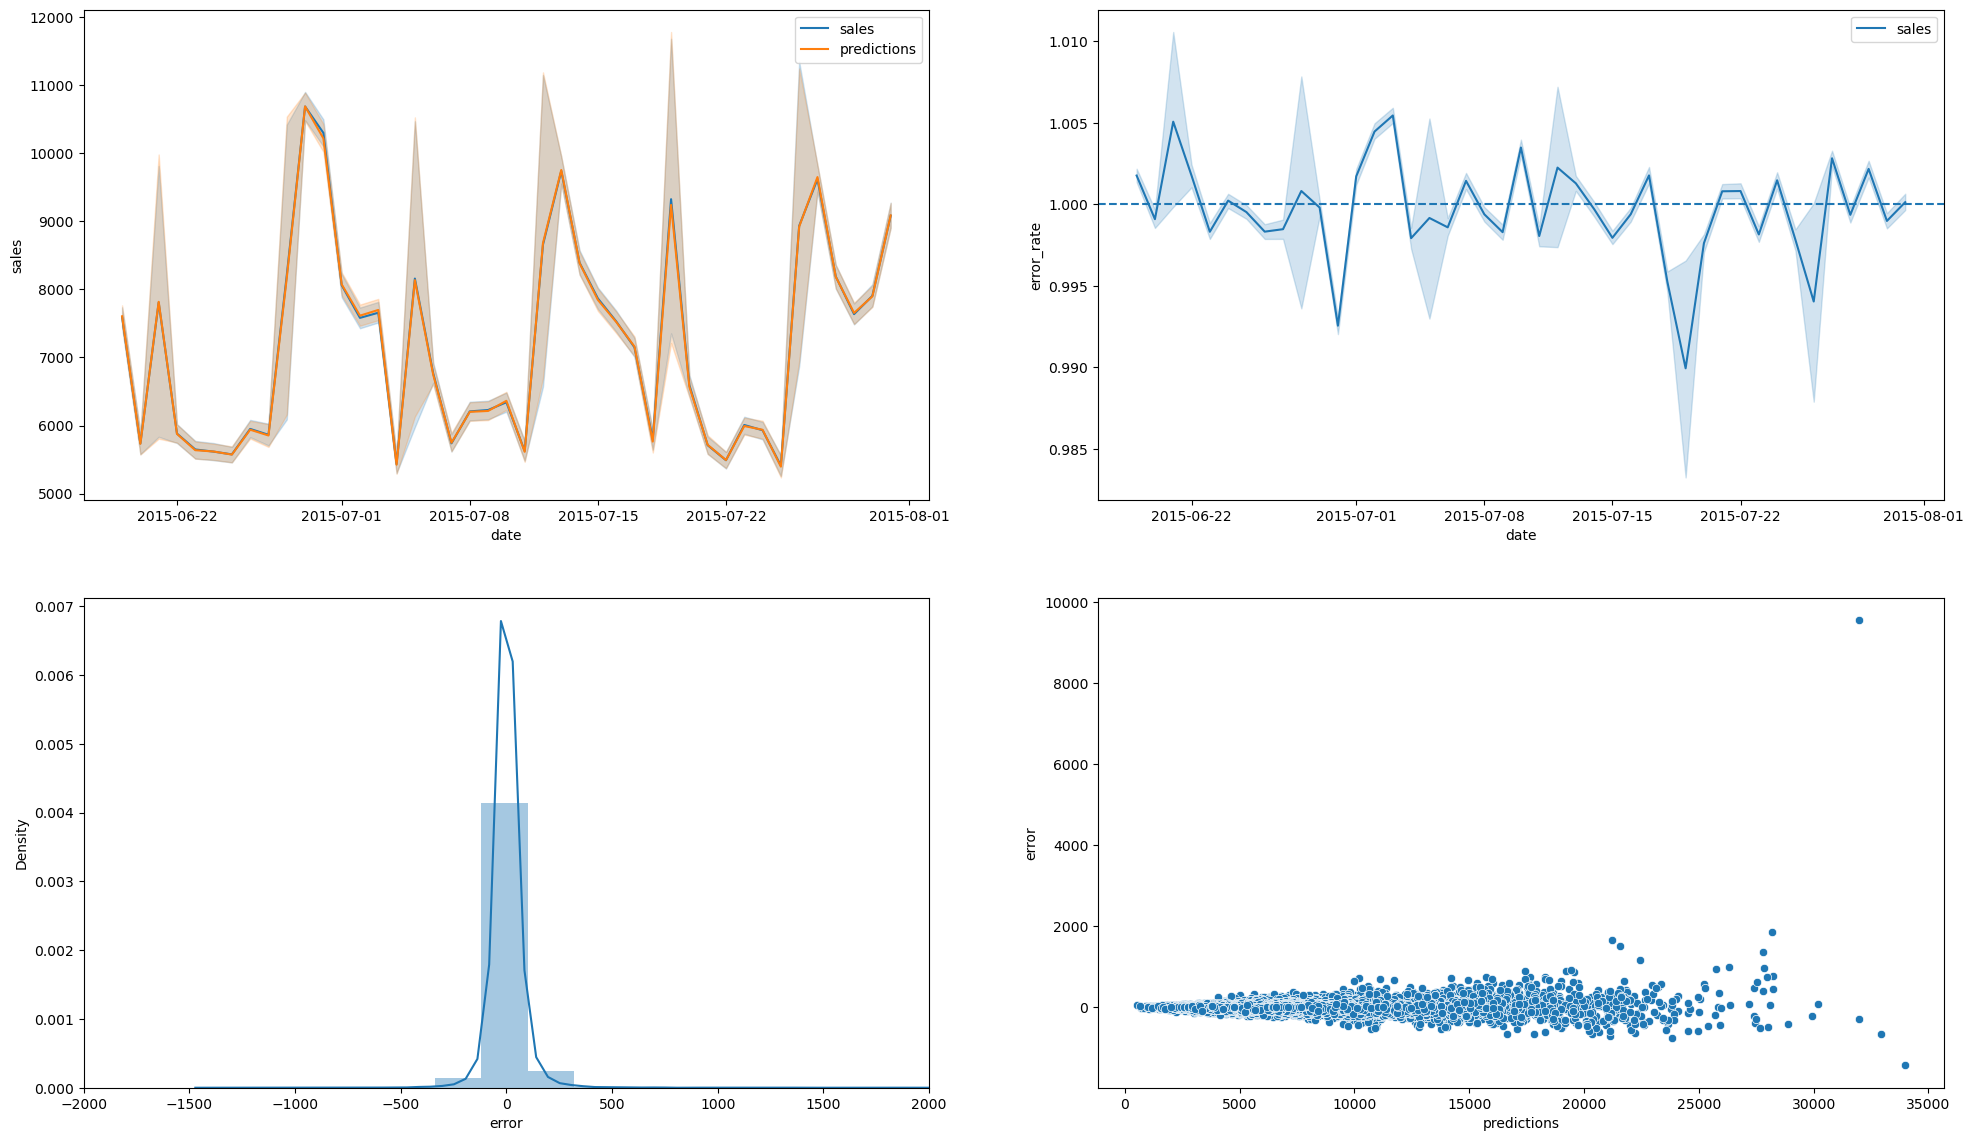

In [193]:
plt.figure(figsize=(24,14))
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df7, label='sales')
sns.lineplot(x='date', y='predictions', data=df7, label='predictions')
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df7, label='sales')
plt.axhline(1, linestyle='--')
plt.subplot(2, 2, 3)
sns.distplot(df7['error'])
plt.xlim([-2000, 2000])
plt.subplot(2, 2, 4)
sns.scatterplot(df7['predictions'], df7['error'])



# Deploy

In [264]:
pickle.dump(xgb, open('/home/biazotogabriel/repos/courses/ds_em_producao/model_rossmann.pkl', 'wb'))

## Rossmann Class

In [217]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
from datetime import timedelta



class Rossmann(object):
    def __init__(self):
        self.home_path = ''
        self.competition_distance_rescaler = pickle.load(open(self.home_path+'parameter/competition_distance_rescaler.pkl', 'rb'))
        self.competition_time_month_rescaler = pickle.load(open(self.home_path+'parameter/competition_time_month_rescaler.pkl', 'rb'))
        self.promo_time_week_rescaler = pickle.load(open(self.home_path+'parameter/promo_time_week_rescaler.pkl', 'rb'))
        self.year_rescaler = pickle.load(open(self.home_path+'parameter/year_rescaler.pkl', 'rb'))
        self.store_type_label_encoder = pickle.load(open(self.home_path+'parameter/store_type_label_encoder.pkl', 'rb'))
        self.assortment_ordinal_encoder = pickle.load(open(self.home_path+'parameter/assortment_ordinal_encoder.pkl', 'rb'))

    def data_cleaning(self, df1):
        #rename
        old_cols = df1.columns
        new_cols = list(map(inflection.underscore, old_cols))
        df1.columns = new_cols
        df1['date'] = pd.to_datetime(df1['date'], )
        #fill NAs
        max_value = 10 * df1['competition_distance'].max()
        df1.loc[df1['competition_distance'].isna(), 'competition_distance'] = max_value
        df1['competition_open_since_month'] = df1.apply(lambda row: row['date'].month if math.isnan(row['competition_open_since_month']) else row['competition_open_since_month'], axis=1)
        df1['competition_open_since_year'] = df1.apply(lambda row: row['date'].year if math.isnan(row['competition_open_since_year']) else row['competition_open_since_year'], axis=1)
        df1['promo2_since_week'] = df1.apply(lambda row: row['date'].week if math.isnan(row['promo2_since_week']) else row['promo2_since_week'], axis=1)
        df1['promo2_since_year'] = df1.apply(lambda row: row['date'].year if math.isnan(row['promo2_since_year']) else row['promo2_since_year'], axis=1)
        df1.loc[df1['promo_interval'].isna(), 'promo_interval'] = ''
        #convert dtype
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        #feature engenering
        
        return df1
    
    def feature_engineering(self, df2):
        df2['year'] = df2['date'].dt.year
        df2['month'] = df2['date'].dt.month
        df2['day'] = df2['date'].dt.day
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        df2['competition_since'] = pd.to_datetime({'year': df2['competition_open_since_year'],
                                                'month': df2['competition_open_since_month'],
                                                'day': 1})
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
        df2['promo_since'] = pd.to_datetime(df2['promo2_since_year'] * 1000 + df2['promo2_since_week'] * 10, format='%Y%W%w')
        df2['promo_since'] = df2['promo_since'] - timedelta(days=7)
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
        df2['assortment'] = df2['assortment'].map(lambda x: {'a': 'basic',
                                                            'b': 'extra',
                                                            'c': 'extended'}.get(x, x))
        df2['state_holiday'] = df2['state_holiday'].map(lambda x: {'a': 'public',
                                                                'b': 'easter',
                                                                'c': 'christmas',
                                                                '0': 'regular'}.get(x, x))
        df2 = df2[df2['open'] != 0]
        cols_drop = ['open', 'promo_interval']
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation(self, df5):
        #fit_transform ??
        df5['competition_distance'] = self.competition_distance_rescaler.transform(df5[['competition_distance']].values)
        df5['competition_time_month'] = self.competition_time_month_rescaler.transform(df5[['competition_time_month']].values)
        df5['promo_time_week'] = self.promo_time_week_rescaler.transform(df5[['promo_time_week']].values)
        df5['year'] = self.year_rescaler.transform(df5[['year']].values)

        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
        df5['store_type'] = self.store_type_label_encoder.transform(df5['store_type'])
        df5['assortment'] = self.assortment_ordinal_encoder.transform(df5[['assortment']].values)
        
        #df5['sales'] = np.log1p(df5['sales'])
        
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. *  np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. *  np.pi / 7)))

        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. *  np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. *  np.pi / 12)))

        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. *  np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. *  np.pi / 30)))

        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. *  np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. *  np.pi / 52)))

        #Final cols selected according with boruta
        selected = [
            'store', 
            'promo', 
            'store_type', 
            'assortment', 
            'competition_distance',
            'competition_open_since_month', 
            'competition_open_since_year', 
            'promo2',
            'promo2_since_week', 
            'promo2_since_year', 
            'competition_time_month',
            'promo_time_week', 
            'day_of_week_sin', 
            'day_of_week_cos', 
            'month_sin',
            'month_cos',
            'day_sin', 
            'day_cos',
            'week_of_year_sin', 
            'week_of_year_cos'] 

        feature_add = ['date']#, 'sales'
        #selected.extend(feature_add)

        return df5[selected]

    def get_prediction(self, model, original_data, test_data):
        pred = model.predict(test_data)

        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')

## API Handler

In [216]:
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
import pickle

# loading model
model = pickle.load(open('/home/biazotogabriel/repos/courses/ds_em_producao/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        pipeline = Rossmann()
        df1 = pipeline.data_cleaning(test_raw)
        df2 = pipeline.feature_engineering(df1)
        df3 = pipeline.data_preparation(df2)
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.0.106:5000/ (Press CTRL+C to quit)


## API Tester

In [231]:
import json
import requests


In [219]:
df10 = pd.read_csv('datasets/test.csv')

In [265]:
df_test = df10.merge(df_stores_raw, how='left', on='Store')
df_test

#choose store for prediction
df_test = df_test[df_test['Store'].isin([22])]

df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [266]:
data = json.dumps(df_test.to_dict(orient='records'))

In [282]:
#API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://ds-em-producao-deploy.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 500


In [281]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [277]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R$ {:,.2f} in the next 6 week'.format(
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction']
    ))

Store Number 22 will sell R$ 185,680.34 in the next 6 week
